In [63]:
project_name="anime-dcgan"

### Get Dataset

In [64]:
# import opendatasets as od
# dataset_url = "https://www.kaggle.com/splcher/animefacedataset"
# od.download(dataset_url)

In [65]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [66]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normallize RGB to 0.5

In [67]:
train_ds = ImageFolder('./animefacedataset',transform=T.Compose([
  T.Resize(image_size),#resize to 64x64
  T.CenterCrop(image_size),#center crop to 64x64
  T.ToTensor(),#convert to tensor
  T.Normalize(*stats)]))#normalize to 0.5 from (0,1) to (-1,1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [68]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
def denorm(img_tensors):
    """take image_tensor multiply with standard deviation and add the mean value. Bring it back to (0,1)"""
    return img_tensors * stats[1][0] + stats[0][0]

In [70]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

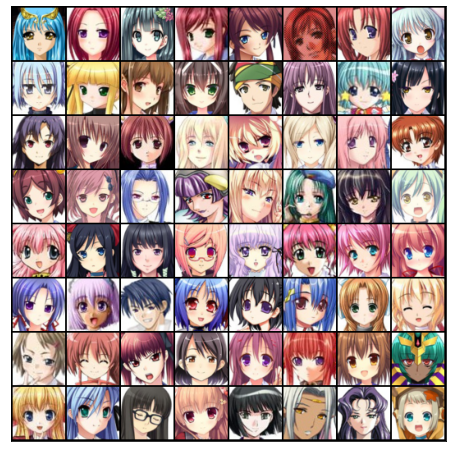

In [71]:
show_batch(train_dl)

In [72]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [73]:
device = get_default_device()
device

device(type='cuda')

In [74]:
train_dl = DeviceDataLoader(train_dl, device)

### Discriminator Network

In [75]:
# Classifier model (DCGAN)
import torch.nn as nn

discriminator = nn.Sequential(
    # input is 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # output is 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # output is 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # output is 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # output is 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # output is 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()  # output is a probability
    # classification use softmax, but generation use sigmoid
)


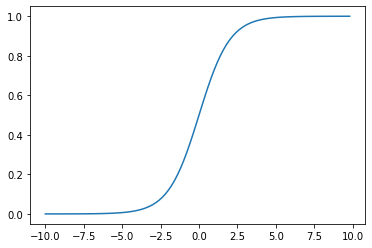

In [76]:
import math
import numpy as np


def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a


x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x, sig)
plt.show()


In [77]:
discriminator = to_device(discriminator, device)

In [78]:
latent_size = 128 # controller number, more latent more feature e.g. human face 1024 

In [79]:
generator = nn.Sequential(
  #input: latent_size x 1 x 1
  nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
  nn.BatchNorm2d(512),
  nn.ReLU(True),
  #output: 512 x 4 x 4

  nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(256),
  nn.ReLU(True),
  #output: 256 x 8 x 8

  nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(128),
  nn.ReLU(True),
  #output: 128 x 16 x 16

  nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(True),
  #output: 64 x 32 x 32

  nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
  nn.Tanh()
  #output: 3 x 64 x 64
)

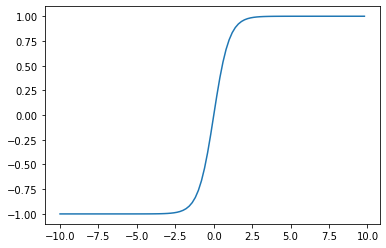

In [80]:
## value from (-1,1)
def tanh(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a

x = np.arange(-10., 10., 0.2)
tan = tanh(x)
plt.plot(x, tan)
plt.show()

torch.Size([128, 3, 64, 64])


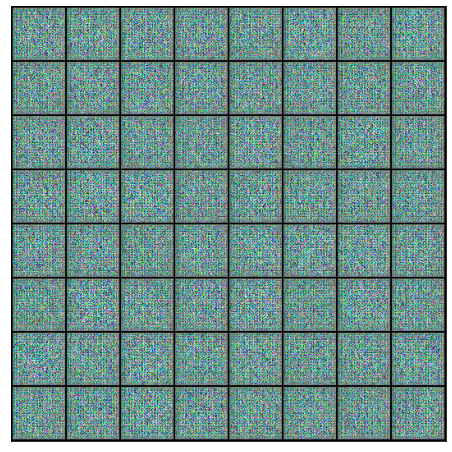

In [81]:
# Create random latent vector
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [82]:
generator = to_device(generator, device)

### Discriminator Network Training

use binary crossentrophy loss

In [83]:
import torch.nn.functional as F

In [84]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score


### Generator Network Training

In [85]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [86]:
from torchvision.utils import save_image
import os
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

In [87]:
def save_samples(index,latent_tensors,show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{:04d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
      fig, ax = plt.subplots(figsize=(8, 8))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [88]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


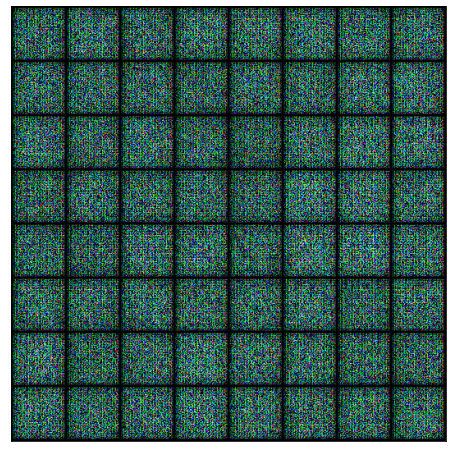

In [89]:
save_samples(0, fixed_latent)

In [90]:
from tqdm.notebook import tqdm

In [91]:
def fit(epochs,lr,start_idx=1):
  torch.cuda.empty_cache()

  #loss and score
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  #Create Optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    #Train generator and discriminator
    for real_images, _ in tqdm(train_dl):
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g = train_generator(opt_g)
    
    #keep record and score
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    #log losses & scorees (last batch)
    print(f"Epoch [{epoch+1}/{epochs}] Loss_D: {loss_d} Loss_G: {loss_g} Real_Score: {real_score} Fake_Score: {fake_score}")

    #save samples
    save_samples(epoch+start_idx, fixed_latent)

  return losses_g, losses_d, real_scores, fake_scores

In [92]:
lr = 0.0002
epochs = 25

In [93]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/25] Loss_D: 1.2328720092773438 Loss_G: 1.6602611541748047 Real_Score: 0.3787948191165924 Fake_Score: 0.007978010922670364
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [2/25] Loss_D: 0.3108522295951843 Loss_G: 4.662623882293701 Real_Score: 0.82000732421875 Fake_Score: 0.04692143201828003
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [3/25] Loss_D: 0.4429295063018799 Loss_G: 5.022486686706543 Real_Score: 0.7107396125793457 Fake_Score: 0.0166623555123806
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [4/25] Loss_D: 0.10016963630914688 Loss_G: 5.43035888671875 Real_Score: 0.92112135887146 Fake_Score: 0.008728050626814365
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [5/25] Loss_D: 0.14732643961906433 Loss_G: 3.6037776470184326 Real_Score: 0.9022476673126221 Fake_Score: 0.012458436191082
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [6/25] Loss_D: 0.19872625172138214 Loss_G: 6.333705902099609 Real_Score: 0.8541467785835266 Fake_Score: 0.006784920580685139
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [7/25] Loss_D: 0.12435246258974075 Loss_G: 8.142428398132324 Real_Score: 0.900468111038208 Fake_Score: 0.0008838706999085844
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [8/25] Loss_D: 0.12712985277175903 Loss_G: 4.820977210998535 Real_Score: 0.8970347046852112 Fake_Score: 0.002365756779909134
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [9/25] Loss_D: 0.5980470180511475 Loss_G: 9.678934097290039 Real_Score: 0.6231617331504822 Fake_Score: 5.788779162685387e-05
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [10/25] Loss_D: 0.4365292489528656 Loss_G: 7.403250217437744 Real_Score: 0.7348169684410095 Fake_Score: 0.00013370643137022853
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [11/25] Loss_D: 0.09483306854963303 Loss_G: 7.90324592590332 Real_Score: 0.9231854677200317 Fake_Score: 0.003806960303336382
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [12/25] Loss_D: 0.5567393898963928 Loss_G: 9.105527877807617 Real_Score: 0.9998510479927063 Fake_Score: 0.3463813364505768
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [13/25] Loss_D: 0.14052295684814453 Loss_G: 4.304443836212158 Real_Score: 0.9307641386985779 Fake_Score: 0.05367419868707657
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [14/25] Loss_D: 0.2041085958480835 Loss_G: 5.425992012023926 Real_Score: 0.9143138527870178 Fake_Score: 0.0976378321647644
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [15/25] Loss_D: 0.29729804396629333 Loss_G: 2.3514351844787598 Real_Score: 0.8379013538360596 Fake_Score: 0.05404474958777428
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [16/25] Loss_D: 0.42465054988861084 Loss_G: 1.5029278993606567 Real_Score: 0.7403952479362488 Fake_Score: 0.017196588218212128
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [17/25] Loss_D: 0.17954587936401367 Loss_G: 6.850616455078125 Real_Score: 0.9899613857269287 Fake_Score: 0.14013636112213135
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [18/25] Loss_D: 0.15965422987937927 Loss_G: 3.7581300735473633 Real_Score: 0.9248976111412048 Fake_Score: 0.0686042532324791
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [19/25] Loss_D: 0.17879845201969147 Loss_G: 4.75193977355957 Real_Score: 0.9344343543052673 Fake_Score: 0.09002694487571716
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [20/25] Loss_D: 0.09298604726791382 Loss_G: 3.9717230796813965 Real_Score: 0.9637819528579712 Fake_Score: 0.051344335079193115
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');